In [9]:
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [ ]:
# --- 1. Llegir tots els CSV locals ---
data_path = Path("/Users/guillemlopezcolomer/Desktop/tfg/traffic-prediction-tfg/data/Estat_transit/") / "*.csv"

df = pl.scan_csv(str(data_path))

In [10]:
# --- 2. Crear timestamp correcte ---
df = df.with_columns(
    pl.col("data")
      .cast(pl.Utf8)  # passa d'enter a text
      .str.strptime(pl.Datetime, format="%Y%m%d%H%M%S")
      .alias("timestamp")
)

In [16]:
df = pl.read_parquet("dataset_1y.parquet")

daily = (
    df
    .with_columns(pl.col("timestamp").dt.truncate("1d").alias("day"))
    .group_by("day")
    .agg([
        (pl.col("estatActual").is_in([1,2,3,4,5]).mean() * 100).alias("pct_useful"),
        (pl.col("estatActual").is_in([0,6]).mean() * 100).alias("pct_missing")
    ])
    .sort("day")
)

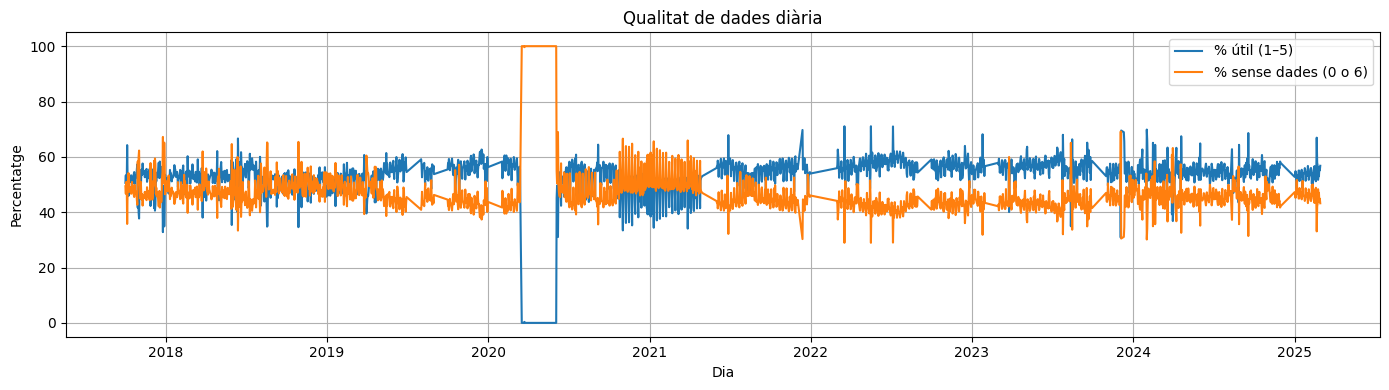

In [12]:
plt.figure(figsize=(14,4))
plt.plot(daily["day"], daily["pct_useful"], label="% útil (1–5)")
plt.plot(daily["day"], daily["pct_missing"], label="% sense dades (0 o 6)")
plt.ylabel("Percentatge")
plt.xlabel("Dia")
plt.title("Qualitat de dades diària")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
monthly = (
    daily.with_columns(daily["day"].dt.strftime("%Y-%m").alias("month"))
         .group_by("month")
         .mean()
         .sort("month")
)
print(monthly.sort("pct_useful", descending=True).head(10))

shape: (10, 4)
┌─────────┬─────────────────────┬────────────┬─────────────┐
│ month   ┆ day                 ┆ pct_useful ┆ pct_missing │
│ ---     ┆ ---                 ┆ ---        ┆ ---         │
│ str     ┆ datetime[μs]        ┆ f64        ┆ f64         │
╞═════════╪═════════════════════╪════════════╪═════════════╡
│ 2022-07 ┆ 2022-07-16 00:00:00 ┆ 59.820993  ┆ 40.179007   │
│ 2023-07 ┆ 2023-07-16 00:00:00 ┆ 58.619813  ┆ 41.380187   │
│ 2022-06 ┆ 2022-06-15 12:00:00 ┆ 58.573392  ┆ 41.426608   │
│ 2022-05 ┆ 2022-05-16 00:00:00 ┆ 57.84077   ┆ 42.15923    │
│ 2023-09 ┆ 2023-09-15 12:00:00 ┆ 57.406736  ┆ 42.593264   │
│ 2022-11 ┆ 2022-11-15 12:00:00 ┆ 57.401063  ┆ 42.598937   │
│ 2020-02 ┆ 2020-02-15 00:00:00 ┆ 57.370561  ┆ 42.629439   │
│ 2023-06 ┆ 2023-06-15 12:00:00 ┆ 57.193365  ┆ 42.806635   │
│ 2019-12 ┆ 2019-12-16 00:00:00 ┆ 57.100194  ┆ 42.899806   │
│ 2023-05 ┆ 2023-05-16 00:00:00 ┆ 57.047086  ┆ 42.952914   │
└─────────┴─────────────────────┴────────────┴─────────────┘


In [24]:
# -- 1. Definim els límits de temps
start_2y = pl.datetime(2022, 11, 1)   # 1 novembre 2022
end_2y   = pl.datetime(2024, 10, 31)  # 31 octubre 2024

start_1y = pl.datetime(2023, 11, 1)   # 1 novembre 2023
end_1y   = end_2y                     # mateix final

# Filtrar i col·leccionar
dataset_2y = (
    df.filter((pl.col("timestamp") >= start_2y) & (pl.col("timestamp") <= end_2y))
      .collect()          # <- materialitza a DataFrame
)
dataset_1y = (
    df.filter((pl.col("timestamp") >= start_1y) & (pl.col("timestamp") <= end_1y))
      .collect()
)

# Desa en Parquet
dataset_2y.write_parquet("dataset_2y.parquet")
dataset_1y.write_parquet("dataset_1y.parquet")

In [19]:
df = pl.read_parquet("dataset_1y.parquet")

daily = (
    df
    .with_columns(pl.col("timestamp").dt.truncate("1d").alias("hour"))
    .group_by("hour")
    .agg([
        (pl.col("estatActual").is_in([1,2,3,4,5]).mean() * 100).alias("pct_useful"),
        (pl.col("estatActual").is_in([0,6]).mean() * 100).alias("pct_missing")
    ])
    .sort("hour")
)

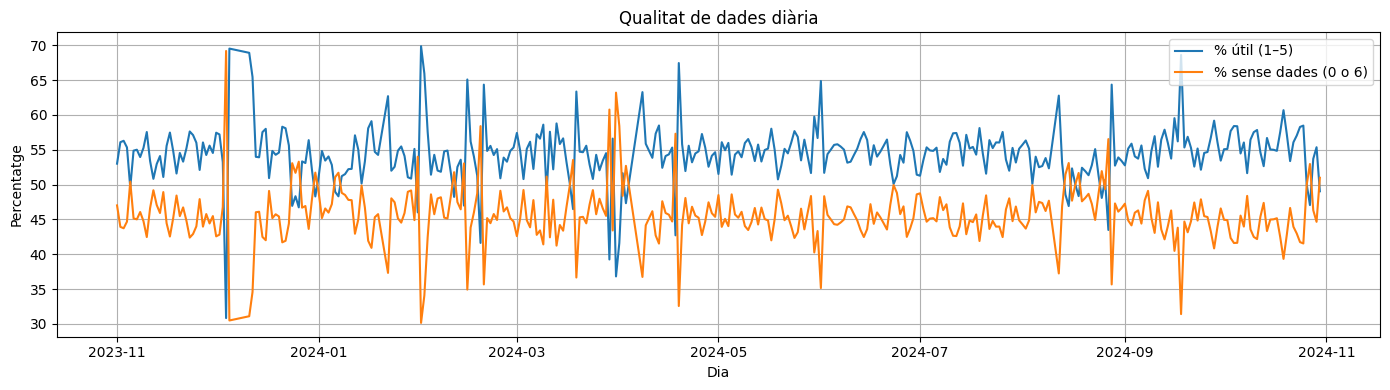

In [20]:
plt.figure(figsize=(14,4))
plt.plot(daily["hour"], daily["pct_useful"], label="% útil (1–5)")
plt.plot(daily["hour"], daily["pct_missing"], label="% sense dades (0 o 6)")
plt.ylabel("Percentatge")
plt.xlabel("Dia")
plt.title("Qualitat de dades diària")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()